## Feature expansion and regularization in sklearn 
This lab teaches you feature expansion and regularization in sklearn

In [1]:
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.preprocessing import PolynomialFeatures
import sklearn.linear_model as skl
from sklearn.model_selection import train_test_split, cross_val_score

## Polynomial expansion 

In [ ]:
# Let's load a data set and look at it.
D=pd.read_csv('regression_data.csv')
plt.plot(D.x, D.y, 'bo')
plt.show()

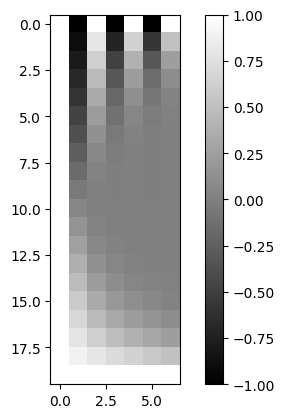

,0,1,2,3,4,5,6
0,1.0,-1.000000,1.000000,-1.000000,1.000000,-1.000000,1.000000
1,1.0,-0.894737,0.800554,-0.716285,0.640887,-0.573425,0.513064
2,1.0,-0.789474,0.623269,-0.492054,0.388464,-0.306682,0.242117
3,1.0,-0.684211,0.468144,-0.320309,0.219159,-0.149951,0.102598
4,1.0,-0.578947,0.335180,-0.194052,0.112346,-0.065042,0.037656


In [3]:
# Build a design matrix with polynomial expansion on X
x=D.x.values
x=x.reshape(-1,1)
poly = sk.preprocessing.PolynomialFeatures(degree=6)
X = poly.fit_transform(x)
plt.imshow(X, cmap='gray')
plt.colorbar()
plt.show()

# Or you can plot them in colour
#plt.imshow(X)
#plt.colorbar()
#plt.show()

XDF = pd.DataFrame(X)
XDF.head()

## Ridge regression

(7,)


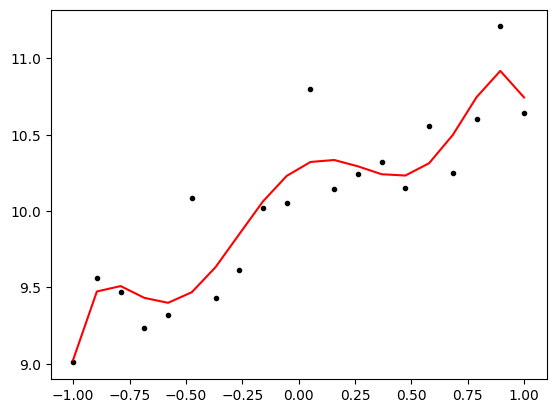

In [4]:
# Now fit a standard linear model to the data and plot prediction 
reg = skl.LinearRegression(fit_intercept=False)
reg.fit(X,D.y)
yp=reg.predict(X)
print(reg.coef_.shape)
plt.plot(x,D.y,'k.',x,yp,'r-')
plt.show()

Coef. matrix shape (7 x 1)


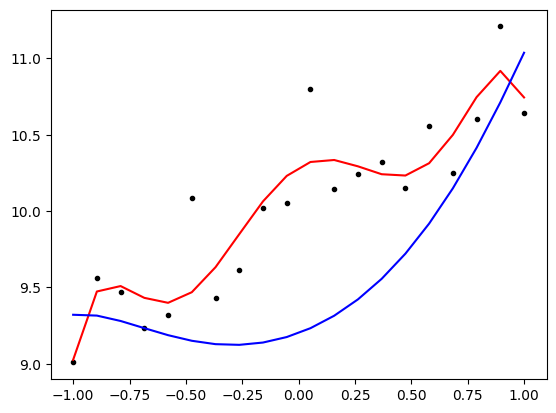

In [5]:
# This seems very wiggly.
# Could we do better with Ridge regression? 
# Let's regulatrize a lot
print('Coef. matrix shape (%i x 1)' % reg.coef_.shape)

ridge = skl.Ridge(alpha=1.0, fit_intercept=False)
ridge.fit(X,D.y)
ypp=ridge.predict(X)
plt.plot(x,D.y,'k.',x,yp,'r-',x,ypp,'b-')
plt.show()

### Fix the intercept problem

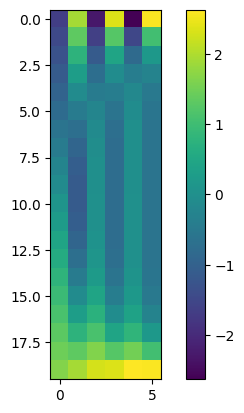

In [6]:
# What happened? 
# The problem is that the Ridge coefficient was also applied to the intercept
# Sometimes this is desired, sometimes not. (Usually not though)
# In this case we do not want to include the intercept 
# into the regressors that should be regularized 
poly = sk.preprocessing.PolynomialFeatures(6, include_bias=0)
X = poly.fit_transform(x)
scaler = sk.preprocessing.StandardScaler(with_mean=True,
                                         with_std=True)
X = scaler.fit_transform(X)
pd.DataFrame(X).head()
plt.imshow(X)
plt.colorbar()
plt.show()

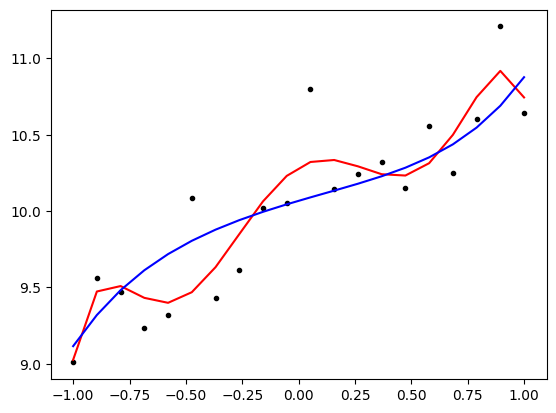

In [7]:
# If we set fit_intercept = True (default), 
# ridge regression fits the intercept 
ridge = skl.Ridge(alpha=5.0, fit_intercept=True)
ridge.fit(X,D.y)
ypp=ridge.predict(X)
plt.plot(x,D.y,'k.',x,yp,'r-',x,ypp,'b-')
plt.show()

In [8]:
# Also redo the linear regression 
reg = skl.LinearRegression(fit_intercept=True)
reg.fit(X,D.y)

LinearRegression()

In [9]:
# Now inspect the coefficients: No explicit intercept is fitted - ridge coefficients are smaller 
(reg.coef_,ridge.coef_)

(array([ 0.5259425 , -1.22248473, -0.14851093,  2.98075495,  0.12675624,
        -1.85398615]),
 array([ 0.26264477, -0.03604224,  0.12595432,  0.01336734,  0.06098453,
        -0.0009332 ]))

### How to set the regularization coefficent? 

In [10]:
# So, how should we tune the regularization coefficient? 
# Let's use crossvalidation 
cv_scores = cross_val_score(skl.LinearRegression(), X, D.y, cv=5, scoring = 'neg_mean_squared_error')
-cv_scores

array([2.59262227e+02, 2.40636938e-01, 9.21051190e-02, 1.01115077e-01,
       7.09633014e+01])

In [11]:
# Systematically vary the ridge coeficient on a log-scale
lam = np.exp(np.linspace(-4,2,10))
mse = np.zeros(10)
for i in range(lam.size):
    cv_scores = cross_val_score(skl.Ridge(alpha=lam[i]), X, D.y,cv=5,scoring = 'neg_mean_squared_error')
    mse[i]=-cv_scores.mean()

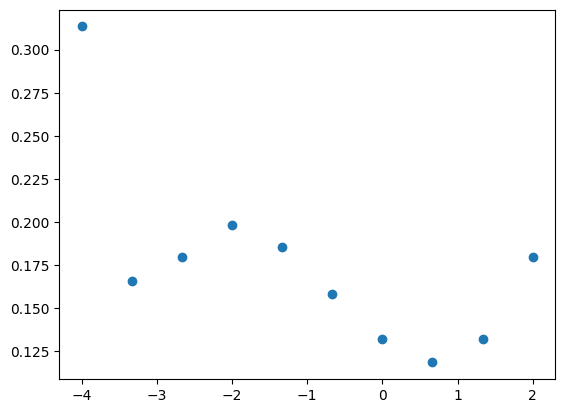

In [12]:
# Determine lowest value 
plt.scatter(np.log(lam),mse)
plt.show()

In [13]:
# So low let's look at the crossvalidation error for the best setting of lambda 
cv_scores = cross_val_score(skl.Ridge(alpha=np.exp(0.8)), X, D.y,cv=5)
print('CV score for alpha=exp(0.8): %.3f' % -cv_scores.mean())

CV score for alpha=exp(0.8): 0.443


### Lasso 

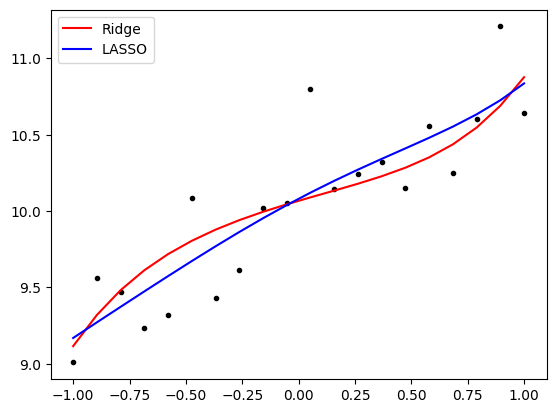

In [14]:
las = skl.Lasso(alpha=0.005, fit_intercept=True)
las.fit(X,D.y)
yl=las.predict(X)
plt.plot(x, D.y, 'k.', label='_nolegend_')
plt.plot(x, ypp, 'r-', label='Ridge')
plt.plot(x, yl, 'b-', label='LASSO')
plt.legend()
plt.show()

In [15]:
# Let's check the coefficients. 
# What do you notice compared to the ridge? 
pd.DataFrame({'Ridge': ridge.coef_,
              'LASSO': las.coef_})

,Ridge,LASSO
0,0.262645,0.471172
1,-0.036042,-0.065772
2,0.125954,0.000000
3,0.013367,0.039328
4,0.060985,0.021967
5,-0.000933,0.000000


### Lasso Path 

minimum regularization parameter : 0.002
maximum regularization parameter : 0.494


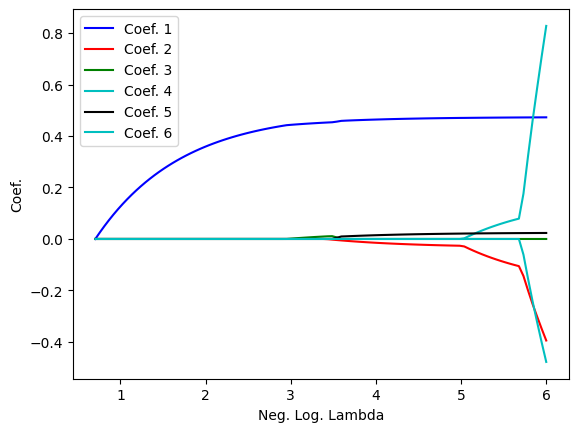

In [16]:
# Get a full path for Lasso
eps = 5e-3 # The smaller eps, the longer the path  
lambda_lasso, coefs_lasso, _ = skl.lasso_path(X, D.y, eps=eps, n_alphas=100, alphas= None)

print(f'minimum regularization parameter : %.3f'% np.amin(lambda_lasso))
print(f'maximum regularization parameter : %.3f' % np.amax(lambda_lasso))
#plt.plot(lambda_lasso)


colors = ['b', 'r', 'g', 'c', 'k','c']
neg_log_lambda = -np.log(lambda_lasso)
for i in range(6):
    l1 = plt.plot(neg_log_lambda, coefs_lasso[i,], c=colors[i])

plt.xlabel('Neg. Log. Lambda')
plt.ylabel('Coef.')
plt.legend(['Coef. 1', 'Coef. 2', 'Coef. 3',
           'Coef. 4', 'Coef. 5', 'Coef. 6'])
plt.show()

## Automatically searching for best hyperparameters (and ElasticNet)

In [17]:
# Create ElasticNet object
ElasticNet = skl.ElasticNetCV(eps=eps, n_alphas=10, 
                              l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
                              alphas=None,
                              fit_intercept=True, max_iter=1000,
                              tol=0.001, cv=3, 
                              n_jobs=2,
                              random_state=20220214)

In [18]:
# Fit it
ElasticNet.fit(X, D.y)

ElasticNetCV(cv=3, eps=0.005, l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
             n_alphas=10, n_jobs=2, random_state=20220214, tol=0.001)

In [19]:
# Print best coefficients
print('Best fit: alpha=%.3f, l1_ratio=%.3f' % 
      (ElasticNet.alpha_, ElasticNet.l1_ratio_))

Best fit: alpha=0.006, l1_ratio=0.700


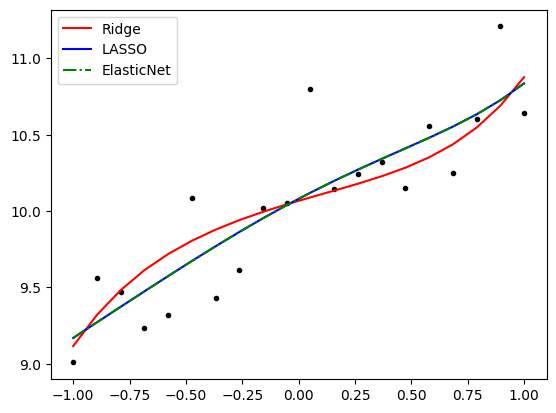

In [20]:
# Plot fit
yen=las.predict(X)
plt.plot(x, D.y, 'k.', label='_nolegend_')
plt.plot(x, ypp, 'r-', label='Ridge')
plt.plot(x, yl, 'b-', label='LASSO')
plt.plot(x, yen, 'g-.', label='ElasticNet')
plt.legend()
plt.show()

In [21]:
# Compare coefficients
pd.DataFrame({'Ridge': ridge.coef_,
              'LASSO': las.coef_,
             'Elastic Net': ElasticNet.coef_})

,Ridge,LASSO,Elastic Net
0,0.262645,0.471172,0.468552
1,-0.036042,-0.065772,-0.072881
2,0.125954,0.000000,0.000000
3,0.013367,0.039328,0.046610
4,0.060985,0.021967,0.024632
5,-0.000933,0.000000,-0.000000
